In [11]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
from numpy.linalg import inv
from numpy import linalg as LA
from sklearn import preprocessing
from sklearn.metrics import classification_report
import time
from datetime import date, datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
# import pywt
# from bartpy.sklearnmodel import SklearnModel
from spock_datastore.symboldb import SymbolDb
from spock_datastore.economicdb import EconomicDb
symbol_db = SymbolDb('http://api.leadinfo.com.tw/api/v1/')
economic_db = EconomicDb('http://api.leadinfo.com.tw/api/v1/')
import datetime
from matplotlib.patches import Rectangle

In [12]:
weight = {'TLT':0.2, 'HYG':0.2, 'EMB':0.2, 'LQD':0.3, '^GSPC':0.1}

In [13]:
class risk_cal:
    def __init__(self, weight, year = None, start = datetime.datetime(2007,1,1), end = datetime.datetime.today()):
        # input
        self.__version = '1.0.0'
        self.__log_info = {}
        self.__wei = weight
        self.__year = str(year)
        self.__start = start
        self.__end = end
        # output
        self.__output = {}
        #information
        self.__info = {}
    @property   
    def Version(self):
        return self.__version
    
    @property   
    def Info(self):
        self.__info['port_value'] = self.__port_value.copy()
        self.__info['symbol_price'] = self.__tv.copy()
        self.__info['simulation_df'] = self.__simulation_df.copy()
        return self.__info
    
    @property
    def Result(self):
        return self.__output
    
    def __check_weight(self):
        if np.array(list(self.__wei.values())).sum() != 1.:
            return False
        else:
            return True
        
    def __risk_dis(self, wei):
        x = np.array(list(self.__wei.values()))
        mad = np.abs(np.subtract.outer(x, x)).mean()
        rmad = mad/np.mean(x)
        gini = 0.5 * rmad
        rd = 1 - gini
        return rd
    
    def __div_ratio(self, tv, wei, pt_val):
        port_val = pt_val.copy()
        port_risk = port_val.pct_change(1).std()
        cols = tv.columns.tolist()
        np_val = []
        for col in cols:
            tmp_tv = tv[col].dropna()
            tmp_val = 10000. / tmp_tv.iloc[0] * tmp_tv
            np_val.append(tmp_val.pct_change(1).std())
        avg_asset_risk = (np.array(np_val) * np.array(list(wei.values()))).sum()
        dr = 1 - port_risk / avg_asset_risk
        return dr
    
    def __mean_corr(self, tv):
        A = tv.pct_change().dropna().corr().values
        m = A.shape[0]
        r,c = np.triu_indices(m,1)
        mu_cor = A[r,c].mean()
        return mu_cor
    
    def __CDI(self, dr, rd):
        cdi = (dr + rd) / 2
        return cdi
    
    def __tot_price(self):
        wei = self.__wei
        start = self.__start
        end = self.__end
        symbols = list(wei.keys())
        tot_price = pd.DataFrame()
        for symbol in symbols:
            tmp = symbol_db.dataReader(symbol, start, end, 'D', 'db')
            tot_price = pd.concat([tot_price, tmp['Adj Close']], axis=1)
        tot_price.columns = symbols
        tot_price = tot_price.fillna(method='pad')
        if self.__year != None:
            tot_price = tot_price.loc[str(self.__year)]
        self.__tv = tot_price
        return True
    
    def __port_value(self):
        tv = self.__tv.copy()
        wei = self.__wei.copy()
        w = np.array([wei[k] for k in tv.columns.tolist()])
        l = tv.shape[0]
        tot_w = pd.DataFrame(np.repeat(w.reshape(-1,1).T,l,axis=0), index = tv.index, columns =tv.columns.tolist())
        tot_w = tot_w.mask(tv.isnull())
        tot_w = tot_w.loc[:,:].div(tot_w.sum(axis=1), axis=0)
        tot_val = []
        val = 10000.
        change_wei_date = tot_w.drop_duplicates(keep='first').index.tolist()
        for t in tot_w.index.tolist():
            if t in change_wei_date:
                share = tot_w.loc[t] * val / tv.loc[t]
            val = (share * tv.loc[t]).sum()
            tot_val.append(val)
        port_val = pd.Series(tot_val, index = tot_w.index)
        self.__port_value = port_val
        return True
    
    def __sim(self, pt_val):       
        port_val = pt_val.copy() 
        port_rets = port_val.pct_change().dropna()
        daily_vol = port_rets.std()
        daily_ret = port_rets.mean()

        simulation_df = pd.DataFrame()
        num_simulations = 10000
        predicted_days = 252
        last_price = port_val.iloc[-1]

        #Create Each Simulation as a Column in df
        for x in range(num_simulations):

            count = 0

            price_series = []
            price_series.append(last_price)

            #Series for Preditcted Days
            for i in range(predicted_days):
                if count == 251:
                    break

                #price = price_series[count] + price_series[count] * (daily_ret + daily_vol * np.random.normal(0, 1))

                price = price_series[count] * (1 + np.random.normal(0, daily_vol))

                price_series.append(price)
                count += 1

            simulation_df[x] = price_series

        self.__simulation_df = simulation_df
        price_array = simulation_df.iloc[-1, :]
        price_array = sorted(price_array, key=int) 

        var = np.percentile(price_array/last_price -1, .95)
        var1 = np.percentile(price_array/last_price -1, .99)
        var2 = np.percentile(price_array/last_price -1, .9999)
        return var, var1, var2
    
    def __cal(self):
        tv = self.__tv.copy()
        wei = self.__wei.copy()
        pt_val = self.__port_value.copy()
        rd = self.__risk_dis(wei)
        dr = self.__div_ratio(tv, wei, pt_val)
        mu_corr = self.__mean_corr(tv)
        cdi = self.__CDI(dr, rd)
        var, var1, var2 = self.__sim(pt_val)
        VaR = {'0.95%CI':var, '0.99%CI':var1,'0.9999%CI':var2}
        self.__output['diversify_ratio'] = dr
        self.__output['risk_dispersion'] = rd
        self.__output['cdi'] = cdi
        self.__output['mean_corr'] = mu_corr
        self.__output['var'] = VaR
        return True
    
    def port_var_plot(self):
        port_val = self.__port_value.copy()
        simulation_df = self.__simulation_df.copy()
        last_price = port_val.iloc[-1]

        price_array = simulation_df.iloc[-1, :]
        price_array = sorted(price_array, key=int) 
        
        var = self.__output['var']
        
        print("VaR at 95% Confidence: " + '{:,.4f}'.format(var['0.95%CI']))
        print("VaR at 99% Confidence: " + '{:,.4f}'.format(var['0.99%CI']))
        print("VaR at 99.99% Confidence: " + '{:,.4f}'.format(var['0.9999%CI']))
        fig, ax = plt.subplots(figsize=(20, 10))
        bin_num = 30
        ret_array = price_array / last_price -1
        N, bins, patches = ax.hist(ret_array, bins=bin_num, edgecolor='white', linewidth=1, rwidth=0.3, density=True)
        cut_pot1 = int(round(bin_num * 0.05))
        cut_pot2 = int(np.argmin(abs(bins)))
        cut_pot3 = int(round(bin_num * 0.95))

        cmap = plt.get_cmap('jet')
        low = cmap(0.5)
        medium =cmap(0.25)
        high = cmap(0.8)
        too_high = cmap(1)

        for i in range(0,cut_pot1):
            patches[i].set_facecolor(low)
        for i in range(cut_pot1,cut_pot2):    
            patches[i].set_facecolor(medium)
        for i in range(cut_pot2, cut_pot3):
            patches[i].set_facecolor(high)
        for i in range(cut_pot3, len(patches)):
            patches[i].set_facecolor(too_high)

        #create legend
        handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [low, medium, high, too_high]]
        labels= ["Shortfall", "Negative Returns", "Positive Returns", "Upside"]
        ax.legend(handles, labels, loc=0, fontsize='medium')

        ax.set_xlabel('Return')
        ax.set_ylabel('Probability')
        ax.set_title(r'Histogram of Simulated Stock Returns', fontsize=18, fontweight='bold')

        fig.show() 
    
    def run(self):
        if not self.__check_weight():
            self.__log('Error', 'Exception: check_weight()')
            return False
        if not self.__tot_price():
            self.__log('Error', 'Exception: tot_price()')
            return False
        if not self.__port_value():
            self.__log('Error', 'Exception: port_values()')
            return False
        if not self.__cal():
            self.__log('Error','Exception: cal()')
            return False
        return True

In [14]:
rc = risk_cal(weight, '2010')

In [15]:
rc.run()

True

In [16]:
rc.Result

{'cdi': 0.4971383908592484,
 'diversify_ratio': 0.1542767817184968,
 'mean_corr': 0.159346971838985,
 'risk_dispersion': 0.84,
 'var': {'0.95%CI': -0.12038417927156075,
  '0.99%CI': -0.11892572587615736,
  '0.9999%CI': -0.11853365585859099}}

In [17]:
port_val = rc.Info['port_value']
simulation_df = rc.Info['simulation_df']

In [8]:
rc.Result

{'cdi': 0.4971383908592484,
 'diversify_ratio': 0.1542767817184968,
 'mean_corr': 0.159346971838985,
 'risk_dispersion': 0.84,
 'var': {'0.95%CI': -0.12279578527494996,
  '0.99%CI': -0.12181021325917071,
  '0.9999%CI': -0.12166466000307592}}

VaR at 95% Confidence: -0.1228
VaR at 99% Confidence: -0.1218
VaR at 99.99% Confidence: -0.1217


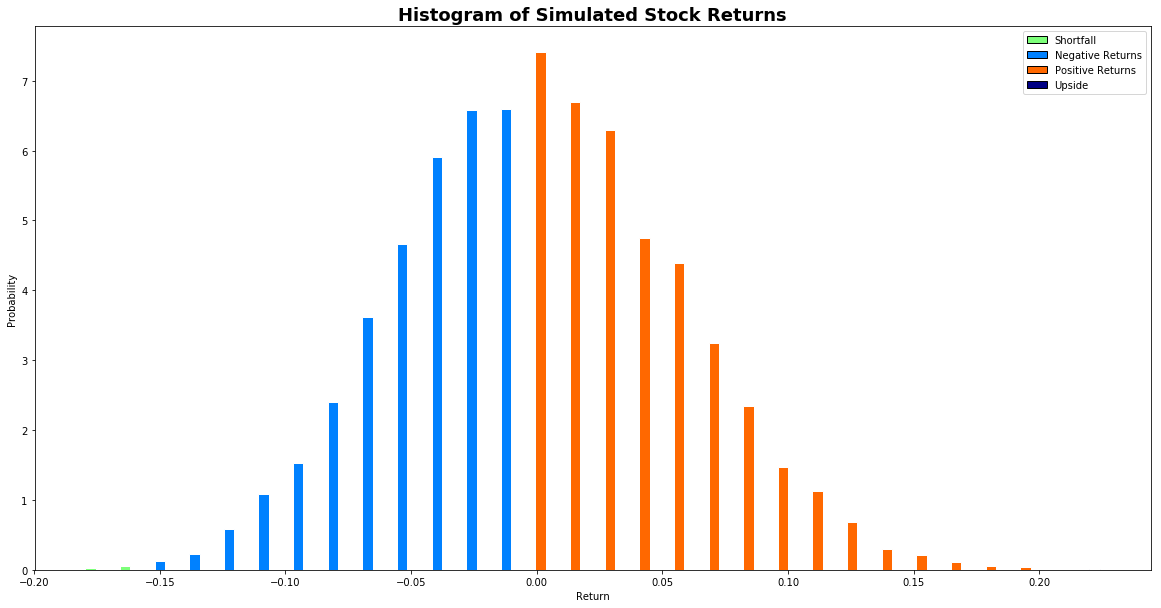

In [9]:
rc.port_var_plot()

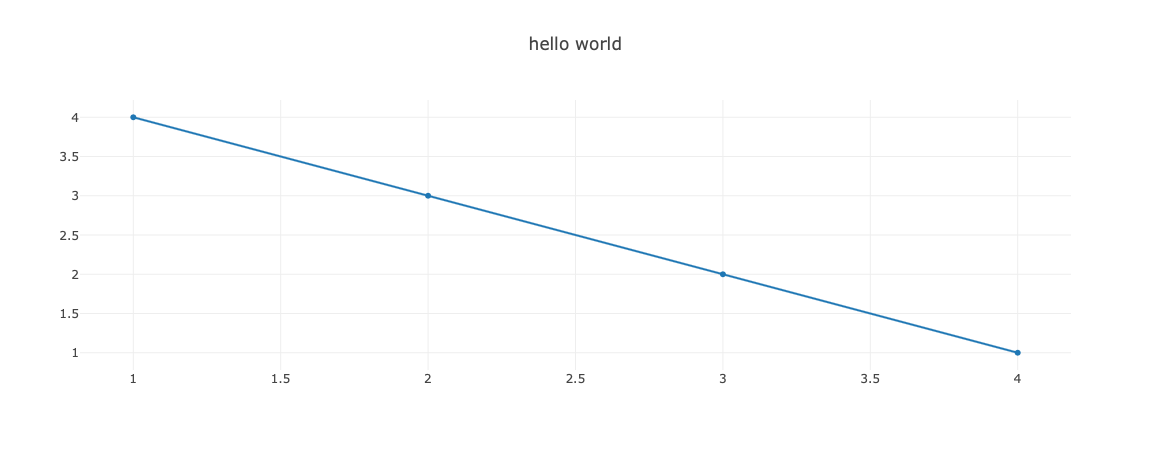

In [6]:
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

plotly.offline.iplot({
    "data": [go.Scatter(x=[1, 2, 3, 4], y=[4, 3, 2, 1])],
    "layout": go.Layout(title="hello world")
})

In [7]:
import plotly.graph_objs as go
x = np.random.randn(1000)
y = np.random.randn(1000)
go.FigureWidget(
    data = [
        {'x':x,'y':y,'type':'histogram2dcontour'}
    ])

FigureWidget({
    'data': [{'type': 'histogram2dcontour',
              'uid': '68b27aa6-02dd-424b-b25a-cd5f1…

In [1]:
import numpy as np